<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Images-of-the-Dataset" data-toc-modified-id="Images-of-the-Dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Images of the Dataset</a></span></li></ul></div>

# Environment Setup
Download and install in Colab required packages and import libraries.

## Images of the Dataset
Downloading of X-ray images of GDXray that are used in these examples.

In [ ]:
!mkdir GDXray
!mkdir GDXray/Settings

!wget https://www.dropbox.com/s/44p6038xek4lord/S0008.zip
!unzip S0008.zip
!rm S0008.zip
!mv S0008 GDXray/Settings/

print('Images of series S0008 of GDXray have been downloaded and stored in directory GDXray/.')


# Geometric calibration

For the calibration of an X-ray computer vision system the X-ray images of a checkerboard (series S0008 of GDXray) and the following Python code can be used. In this example a 3D Gaussian bell is superimposed onto an X-ray image in order to show how we can use the obtained geometric model to reproject 3D points onto the original image.

In [ ]:
# Function extracted from library pyxvis, written by Christian Pieringer, Domingo Mery

def edges_on_chessboard(img, mat_p, square_size, nx=10):
    """
    Projects a the real position of the chessboard edges on the calibration pattern.

    Args:
        img (ndarray): the input image
        mat_p (ndarray): projection matrix
        square_size:
        nx:

    Returns:

    """

    x_max = 10
    y_max = 10

    # Generate a meshgrid with real locations edges on the chessboard
    mat_x = np.arange(nx) * square_size
    mat_y = mat_x.copy()
    mat_x, mat_y = np.meshgrid(mat_x, mat_y)

    # Stack all the edges as a tensor where each cell contains the coordinates
    # of the edge in the real world (chess board).
    edges = np.empty(mat_x.shape + (4,))
    edges[:, :, 0] = mat_x
    edges[:, :, 1] = mat_y
    edges[:, :, 2] = np.zeros(mat_x.shape)
    edges[:, :, 3] = np.ones(mat_y.shape)

    # Using Einstein notation to compute and reduce efficiently the matrices.
    me = np.einsum('ijk, mk->ijm', edges, mat_p).reshape(-1, 3).T
    me = h2nh(me)

    # Plot the results
    fontsize = 14
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img, cmap='gray')
    ax.scatter(me[0, :], me[1, :], marker='o', edgecolor='orange', facecolor='y')

    # Plot the origin of coordinate in the chessboard system
    orig = np.dot(mat_p, np.array([[0], [0], [0], [1]]))
    orig = h2nh(orig)
    ax.plot(orig[0], orig[1], 'ro')
    ax.text(orig[0], orig[1] - 20, 'O', color='w', fontsize=fontsize, weight='bold')


    orig = np.dot(mat_p, np.array([[0], [250], [0], [1]]))
    orig = h2nh(orig)
    ax.plot(orig[0], orig[1], 'bo')
    ax.text(orig[0], orig[1] - 20, 'Y', color='w', fontsize=fontsize, weight='bold')


    orig = np.dot(mat_p, np.array([[250], [0], [0], [1]]))
    orig = h2nh(orig)
    ax.plot(orig[0], orig[1], 'go')
    ax.text(orig[0], orig[1] - 20, 'X', color='w', fontsize=fontsize, weight='bold')

    ax.axis('off')
    plt.show()


def num2fixstr(x,d):
  # example num2fixstr(2,5) returns '00002'
  # example num2fixstr(19,3) returns '019'
  st = '%0*d' % (d,x)
  return st

def load_image(i):
  img = cv.imread('GDXray/Settings/S0008/S0008_'+num2fixstr(i,4)+'.png',cv.IMREAD_GRAYSCALE)
  return img  

def h2nh(m):
    """
    Normalize homogeneous coordinates dividing by element of a vector.

    Args:
        m: vector

    Returns:
        The normalized vector (ndarray)

    """

    return (m / m[-1])



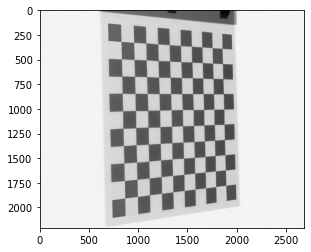

In [ ]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np


img = load_image(6)
plt.imshow(img,cmap='gray')
plt.show()

In [ ]:
# Termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

nx = 10 #  number of inside corners per row
ny = 10 #  number of inside corners per column

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny, 3), np.float32)
objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
objp = 250 * objp

# Arrays to store object points and image points from all the images.
obj_points = [] # 3d point in real world space
img_points = [] # 2d points in image plane.

img_boards = []

for i in range(1, 19):
    
    print('Find chessboard corners in image {}: '.format(i), end='')
    
    img = load_image(i)
    img_h = img.copy()
    
    # Keep a copy of the image but using three color channels. Just for visualization.
    img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
    
    ret, corners = cv.findChessboardCorners(img_h, (nx, ny), flags=cv.CALIB_CB_ADAPTIVE_THRESH)

    print('{}'.format(ret))
    
    if ret:
        obj_points.append(objp)
        corners = cv.cornerSubPix(img_h, corners, (11, 11), (-1, -1), criteria)
        img = cv.drawChessboardCorners(img, (nx, ny), corners, ret)
        img_points.append(corners)
        img_boards.append({'img': img, 'idx': i})

# Calibrate the camera
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(obj_points, img_points, img_h.shape[::-1], None, None)

# Show parameters
print('ret: ', ret)
print('Mtx: ', mtx)
print('Dist: ', dist)
print('Rvecs: ', rvecs)
print('Tvecs: ', tvecs)


Find chessboard corners in image 1: True
Find chessboard corners in image 2: True
Find chessboard corners in image 3: True
Find chessboard corners in image 4: True
Find chessboard corners in image 5: True
Find chessboard corners in image 6: True
Find chessboard corners in image 7: True
Find chessboard corners in image 8: True
Find chessboard corners in image 9: True
Find chessboard corners in image 10: True
Find chessboard corners in image 11: True
Find chessboard corners in image 12: True
Find chessboard corners in image 13: True
Find chessboard corners in image 14: True
Find chessboard corners in image 15: True
Find chessboard corners in image 16: True
Find chessboard corners in image 17: True
Find chessboard corners in image 18: True
ret:  1.3499338789477606
Mtx:  [[7.87406344e+03 0.00000000e+00 1.39003942e+03]
 [0.00000000e+00 7.87808930e+03 9.93992937e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Dist:  [[-8.23509523e-02  2.95189900e+00  4.82577664e-03  4.55037217e-03
  -1

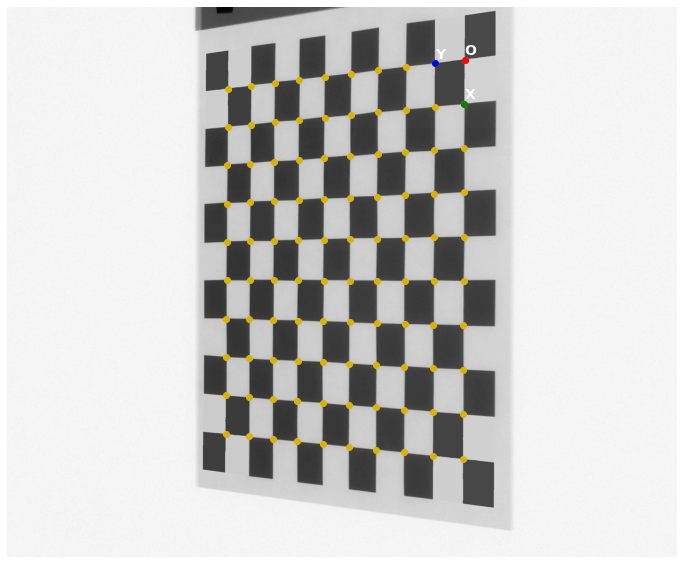

In [ ]:
i = 18
    
# Projection matrix of image i. Remember that for this example
# indexation of rotation and translation matrices starts at 0.
R, _ = cv.Rodrigues(rvecs[i-1])  # Rotation matrix 3x3
t = tvecs[i - 1]  # Translation vector 3x1            

H = np.hstack([R, t])
H = np.vstack([H, np.array([0, 0, 0, 1])])

# Projection matrix
P = np.hstack([mtx, np.zeros((3, 1))])
P = np.dot(P, H)

img = load_image(i)
edges_on_chessboard(img, P, square_size=250)

# Superposition of a Gaussian

In [ ]:
def multivariate_gaussian(pos, mu, sigma):
    """
    Return the multivariate Gaussian distribution on array pos.

    pos is an array constructed by packing the meshed arrays of variables
    x_1, x_2, x_3, ..., x_k into its _last_ dimension.

    [1] https://scipython.com/blog/visualizing-the-bivariate-gaussian-distribution/

    Args:
        pos:
        mu:
        sigma:

    Returns:

    """
    n = mu.shape[0]

    sigma_det = np.linalg.det(sigma)
    sigma_inv = np.linalg.inv(sigma)

    den = np.sqrt(((2 * np.pi) ** n) * sigma_det)

    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k, kl, ...l->...', pos - mu, sigma_inv, pos - mu)

    return np.exp(-fac / 2) / den

def gaussian_superimposition(img, mat_p, square_size, n_points=30):
    """
    This method projects a Gaussian surface on the calibration pattern.
    """

    x_max = 10
    y_max = 10

    # Generate a meshgrid with real locations edges on the chessboard
    mat_x = np.linspace(0, (x_max - 1) * square_size, n_points)
    mat_y = mat_x.copy()
    mat_x, mat_y = np.meshgrid(mat_x, mat_y)

    # Stack all the edges as a tensor where each cell contains the coordinates
    # of the edge in the real world (chess board).
    edges = np.empty(mat_x.shape + (4,))
    edges[:, :, 0] = mat_x
    edges[:, :, 1] = mat_y
    edges[:, :, 2] = np.zeros(mat_x.shape)
    edges[:, :, 3] = np.ones(mat_y.shape)

    # Mean vector and covariance matrix
    mu = np.array([1125, 1125])
    sigma = np.array([[150000, 0.0], [0.0, 150000]])

    # The distribution on the variables X, Y packed into pos.
    z = multivariate_gaussian(edges[:, :, :2], mu, sigma)
    z = (-1000 * z) / np.max(np.max(z))

    # Add Z coordinates to the edges tensor
    edges[:, :, 2] = z

    me = np.einsum('ijk, mk->ijm', edges, mat_p)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img, cmap='gray')

    # Plot lines on the x-axis first
    for ii in range(me.shape[1]):
        l = me[:, ii]
        l = l / l[:, -1][:, np.newaxis]
        ax.plot(l[:, 0], l[:, 1], '-r')

    # And, finally lines on the y-axis
    for ii in range(me.shape[0]):
        l = me[ii, :]
        l = l / l[:, -1][:, np.newaxis]
        ax.plot(l[:, 0], l[:, 1], '-r')

    ax.axis('off')

    # Plot origin of coordinates
    orig = np.dot(mat_p, np.array([[0], [0], [0], [1]]))
    orig = h2nh(orig)
    ax.plot(orig[0], orig[1], 'ro')
    ax.text(orig[0], orig[1] - 20, 'O', fontsize=14, color='y', weight='bold')

    orig = np.dot(mat_p, np.array([[0], [250], [0], [1]]))
    orig = h2nh(orig)
    ax.plot(orig[0], orig[1], 'bo')
    ax.text(orig[0], orig[1] - 20, 'Y', fontsize=14, color='y', weight='bold')

    orig = np.dot(mat_p, np.array([[250], [0], [0], [1]]))
    orig = h2nh(orig)
    ax.plot(orig[0], orig[1], 'go')
    ax.text(orig[0], orig[1] - 20, 'X', fontsize=14, color='y', weight='bold')

    plt.show()


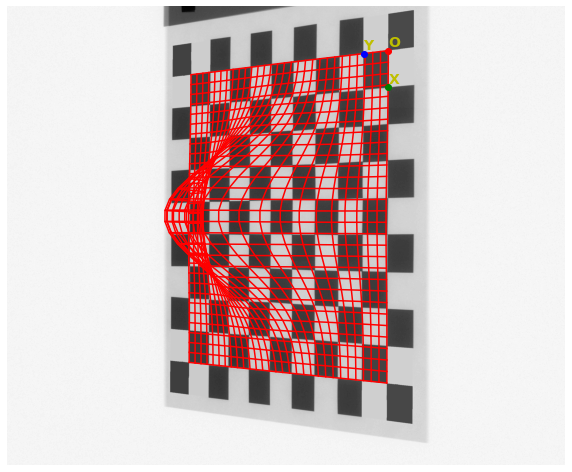

In [ ]:
gaussian_superimposition(img, P, square_size=250, n_points=30)


The output of this code is shown in last Figure. The reader that is interested in the computer graphics details of the superimposition can study the program developed under the name `gaussian_superimposition`.